In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from urllib.request import urlopen, Request
from bs4 import BeautifulSoup
import re
%matplotlib inline

In [85]:
headers = {"User-Agent": "Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/41.0.2228.0 Safari/537.3"}
reg_url = "https://etherscan.io/accounts/label/exchange/1?ps=100"
req = Request(url=reg_url, headers=headers) 
html = urlopen(req).read().decode('utf-8')

In [86]:
res1 = re.findall("address/0x.{40}", html)
res1 = re.findall("0x.{40}", str(res1))

In [87]:
headers = {"User-Agent": "Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/41.0.2228.0 Safari/537.3"}
reg_url = "https://etherscan.io/accounts/label/exchange/2?ps=100"
req = Request(url=reg_url, headers=headers) 
html = urlopen(req).read().decode('utf-8')

In [88]:
res2 = re.findall("address/0x.{40}", html)
res2 = re.findall("0x.{40}", str(res2))

In [89]:
set1 = set().union(res1, res2)
set1.discard("0x71c7656ec7ab88b098defb751b7401b5f6d8976f") # donation address
set1

{'0x0068eb681ec52dbd9944517d785727310b494575',
 '0x0211f3cedbef3143223d3acf0e589747933e8527',
 '0x03bdf69b1322d623836afbd27679a1c0afa067e9',
 '0x03e3ff995863828554282e80870b489cc31dc8bc',
 '0x0536806df512d6cdde913cf95c9886f65b1d3462',
 '0x05f51aab068caa6ab7eeb672f88c180f67f17ec7',
 '0x0681d8db095565fe8a346fa0277bffde9c0edbbf',
 '0x0861fca546225fbf8806986d211c8398f7457734',
 '0x0a73573cf2903d2d8305b1ecb9e9730186a312ae',
 '0x0a869d79a7052c7f1b55a8ebabbea3420f0d1e13',
 '0x0d0707963952f2fba59dd06f2b425ace40b492fe',
 '0x0d6b5a54f940bf3d52e438cab785981aaefdf40c',
 '0x1062a747393198f70f71ec65a582423dba7e5ab3',
 '0x1119aaefb02bf12b84d28a5d8ea48ec3c90ef1db',
 '0x1151314c646ce4e0efd76d1af4760ae66a9fe30f',
 '0x120a270bbc009644e35f0bb6ab13f95b8199c4ad',
 '0x13f64609bf1ef46f6515f8cd3115433a93a00dc6',
 '0x1522900b6dafac587d499a862861c0869be6e428',
 '0x1b6c1a0e20af81b922cb454c3e52408496ee7201',
 '0x1b93129f05cc2e840135aab154223c75097b69bf',
 '0x1c00d840ccaa67c494109f46e55cfeb2d8562f5c',
 '0x1c4b70a39

In [90]:
import json
with open('exchangeAccounts.json', 'w') as json_file:
    json.dump(list(set1), json_file)

In [91]:
len(list(set1))

186

In [3]:
import json;
with open("./secrets/secrets.json") as json_file:  
            secrets = json.load(json_file)


{'WEB3_INFURA_PROJECT_ID': 'a915f690dff94b92bf2251e05f46b591'}

In [4]:
import os;
os.environ["WEB3_INFURA_PROJECT_ID"] = secrets["WEB3_INFURA_PROJECT_ID"]
from web3.auto.infura import w3 as web3

In [5]:
def isNoContract(address= "0xfa52274dd61e1643d2205169732f29114bc240b3"):
    res = web3.eth.getCode(web3.toChecksumAddress(address));
    return not bool(res)

In [94]:
externalExchangeAccounts = [i for i in filter(isNoContract, set1)]

In [95]:
balances = [web3.eth.getBalance(web3.toChecksumAddress(addr)) for addr in externalExchangeAccounts]

In [96]:
data = pd.DataFrame(zip(externalExchangeAccounts, balances), columns=["address", "balance"])

In [97]:
data["balance"] = pd.to_numeric(data["balance"])
data["balance"].idxmax()
data.loc[data["balance"].idxmax()]

address    0x742d35cc6634c0532925a3b844bc454e4438f44e
balance                                   2.16769e+24
Name: 126, dtype: object

Text(0, 0, '0')

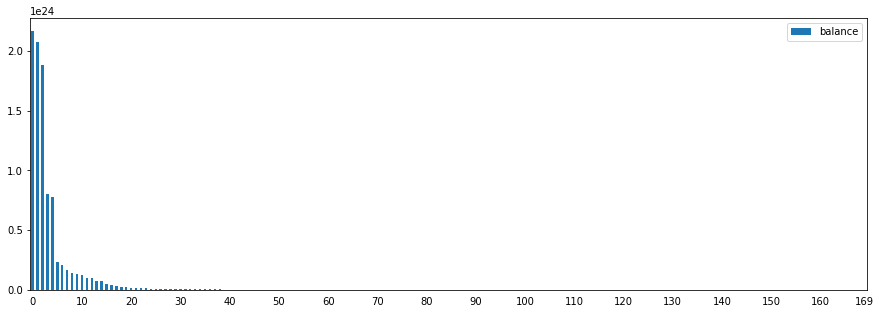

In [98]:
data_sorted = data.sort_values(by="balance", ascending=False)
ax = data_sorted.reset_index(drop=True).plot.bar(xticks=[], figsize=(15,5))
ax.tick_params(
    axis='x',          # changes apply to the x-axis
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=True) # labels along the bottom edge are off

ticketlabels = ax.xaxis.get_ticklabels()
display(ticketlabels[0]) 

for index, ticklabel in enumerate(ticketlabels):
    if (index % 10 == 0 or index == len(ticketlabels) - 1) :
        ticklabel.set_visible(True)
    else:
        ticklabel.set_visible(False)

In [100]:
totalBalance = data_sorted.sum()["balance"];
sum_ = 0;
newData = [];
quantile = 0.8

for index, row in data_sorted.iterrows():
    sum_ = sum_ + row["balance"]
    if (sum_ / totalBalance > quantile):
        break;
    newData.append(row)
    
newData = pd.DataFrame(newData, columns=["address", "balance"])

print("The following {} accounts have more than {} % of the total balance.".format(len(newData), int(quantile * 100)))
display(newData)

The following 4 accounts have more than 80 % of the total balance.


,address,balance
126,0x742d35cc6634c0532925a3b844bc454e4438f44e,2.167694e+24
61,0xbe0eb53f46cd790cd13851d5eff43d12404d33e8,2.074854e+24
21,0xdc76cd25977e0a5ae17155770273ad58648900d3,1.885861e+24
5,0xe853c56864a2ebe4576a807d26fdc4a0ada51919,8.010528e+23


In [102]:
oldBalances = [web3.eth.getBalance(web3.toChecksumAddress(addr), block_identifier=7884000) for addr in newData["address"]]
oldBalances

[1652160364347998500000000,
 661610101010101,
 850860641968887010410000,
 801052799959724594886000]

Funktion bauen um an jedem tag die balances von den 4 adressen zu crawlen

In [111]:
def getSumOfBalances(accounts, block_identifier):
    """Returns list of balances of accounts by queryying an infura node for each account. Takes time."""
    balances = [web3.eth.getBalance(web3.toChecksumAddress(addr), block_identifier=block_identifier) for addr in accounts];
    return sum(balances);

6929462103410824779537944

In [121]:
def getBlocksForDuration(duration="day"):
    if duration == "day":
        return int((24*60*60)/12)
    elif duration == "week":  
        return int((7*24*60*60)/12)
    elif duration == "month":
        return int((30*24*60*60)/12)

In [78]:
def getEveryXthBlock(x):
    latestBlockNumber = web3.eth.getBlock('latest').number;
    return(range(0,latestBlockNumber,x));

[0,
 5,
 10,
 15,
 20,
 25,
 30,
 35,
 40,
 45,
 50,
 55,
 60,
 65,
 70,
 75,
 80,
 85,
 90,
 95,
 100,
 105,
 110,
 115,
 120,
 125,
 130,
 135,
 140,
 145,
 150,
 155,
 160,
 165,
 170,
 175,
 180,
 185,
 190,
 195,
 200,
 205,
 210,
 215,
 220,
 225,
 230,
 235,
 240,
 245,
 250,
 255,
 260,
 265,
 270,
 275,
 280,
 285,
 290,
 295,
 300,
 305,
 310,
 315,
 320,
 325,
 330,
 335,
 340,
 345,
 350,
 355,
 360,
 365,
 370,
 375,
 380,
 385,
 390,
 395,
 400,
 405,
 410,
 415,
 420,
 425,
 430,
 435,
 440,
 445,
 450,
 455,
 460,
 465,
 470,
 475,
 480,
 485,
 490,
 495,
 500,
 505,
 510,
 515,
 520,
 525,
 530,
 535,
 540,
 545,
 550,
 555,
 560,
 565,
 570,
 575,
 580,
 585,
 590,
 595,
 600,
 605,
 610,
 615,
 620,
 625,
 630,
 635,
 640,
 645,
 650,
 655,
 660,
 665,
 670,
 675,
 680,
 685,
 690,
 695,
 700,
 705,
 710,
 715,
 720,
 725,
 730,
 735,
 740,
 745,
 750,
 755,
 760,
 765,
 770,
 775,
 780,
 785,
 790,
 795,
 800,
 805,
 810,
 815,
 820,
 825,
 830,
 835,
 840,
 845,
 8

In [132]:
blocks = getEveryXthBlock(getBlocksForDuration("month"))

In [145]:
from datetime import datetime

balances = []
unixtimestamps = []

for i in blocks:
    balances.append(getSumOfBalances(newData["balance"], i));
    unixtimestamps.append(web3.eth.getBlock(i).timestamp);
    
balances = pd.DataFrame(zip(balances, unixtimestamps))

2015-07-30 15:28:48


In [168]:
balances[1] = [datetime.utcfromtimestamp(ts).strftime('%Y-%m-%d %H:%M:%S') for ts in balances[1]]


TypeError: an integer is required (got type str)

In [171]:
balances = balances.drop(index=0)

In [153]:
balances[0] = balances[0].astype("float")

In [173]:
balances

,0,1
1,0.000000e+00,2015-09-11 02:29:25
2,0.000000e+00,2015-10-24 10:35:32
3,0.000000e+00,2015-12-06 03:23:00
4,0.000000e+00,2016-01-17 21:27:34
5,0.000000e+00,2016-02-29 22:09:18
6,0.000000e+00,2016-04-08 00:38:03
7,0.000000e+00,2016-05-13 21:26:18
8,0.000000e+00,2016-06-18 18:42:31
9,7.791350e+24,2016-07-24 13:09:41
10,7.191340e+24,2016-08-29 07:46:08


Text(0, 0, '2015-09-11 02:29:25')

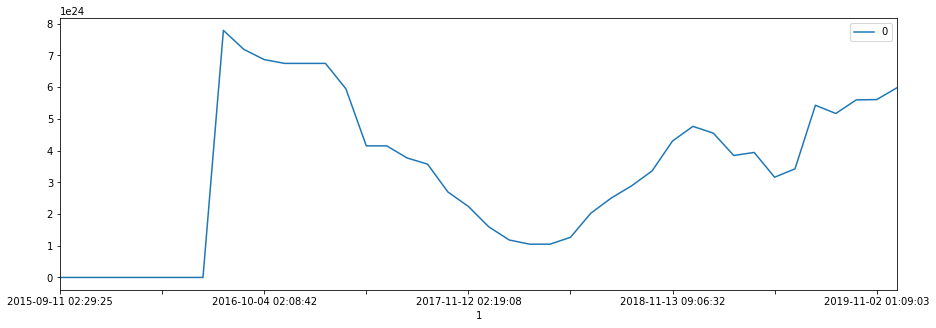

In [175]:
ax = balances.plot(x=1, figsize=(15,5))

ax.tick_params(
    axis='x',          # changes apply to the x-axis
    bottom=True,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=True) # labels along the bottom edge are off

ticketlabels = ax.xaxis.get_ticklabels()
display(ticketlabels[0]) 

for index, ticklabel in enumerate(ticketlabels):
    if (index % 2 == 0 or index == len(ticketlabels) - 1) :
        ticklabel.set_visible(True)
    else:
        ticklabel.set_visible(False)

ConversionError: Failed to convert value(s) to axis units: array(['1970-01-01 00:00:00', '2015-09-11 02:29:25',
       '2015-10-24 10:35:32', '2015-12-06 03:23:00',
       '2016-01-17 21:27:34', '2016-02-29 22:09:18',
       '2016-04-08 00:38:03', '2016-05-13 21:26:18',
       '2016-06-18 18:42:31', '2016-07-24 13:09:41',
       '2016-08-29 07:46:08', '2016-10-04 02:08:42',
       '2016-11-08 23:33:19', '2016-12-14 17:35:50',
       '2017-01-19 09:21:08', '2017-02-24 04:17:24',
       '2017-04-01 06:03:35', '2017-05-08 14:15:42',
       '2017-06-17 15:02:28', '2017-08-01 13:40:55',
       '2017-09-28 20:35:08', '2017-11-12 02:19:08',
       '2017-12-18 03:09:13', '2018-01-25 04:23:52',
       '2018-03-02 16:28:13', '2018-04-07 23:44:04',
       '2018-05-15 04:40:14', '2018-06-22 03:15:26',
       '2018-07-28 23:39:13', '2018-09-03 11:01:36',
       '2018-10-09 01:43:50', '2018-11-13 09:06:32',
       '2018-12-19 00:36:33', '2019-01-26 07:24:45',
       '2019-03-10 21:51:19', '2019-04-13 13:57:10',
       '2019-05-17 06:00:24', '2019-06-20 00:46:14',
       '2019-07-23 16:30:59', '2019-08-26 05:31:37',
       '2019-09-28 22:32:19', '2019-11-02 01:09:03',
       '2019-12-08 13:34:17'], dtype=object)

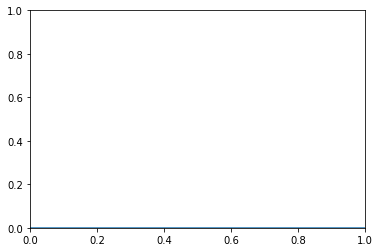

In [154]:
import matplotlib.pyplot as plt
plt.plot(balances)

In [72]:
def timeDecorator(func):
    import time;
    def myWrapper(unixTime = time.time()):
        func(unixTime)
    return myWrapper;

@timeDecorator
def convertUnixTimeToBlock(unixTime):
    print(unixTime)
    web3.eth.getBlock(12345)
    
# f = mydecorator(convertUnixTimeToBlock)
convertUnixTimeToBlock()

1578412900.1913908


In [129]:

from datetime import datetime
ts = int("1438270128")

# if you encounter a "year is out of range" error the timestamp
# may be in milliseconds, try `ts /= 1000` in that case
print(datetime.utcfromtimestamp(ts).strftime('%Y-%m-%d %H:%M:%S'))

2015-07-30 15:28:48


In [30]:
def my_decorator(func):
    def wrapper():
        print("Something is happening before the function is called.")
        func()
        print("Something is happening after the function is called.")
    return wrapper

def say_whee():
    print("Whee!")

say_whee = my_decorator(say_whee)
say_whee()

Something is happening before the function is called.
Whee!
Something is happening after the function is called.


In [144]:
ts = web3.eth.getBlock(10).timestamp
from datetime import datetime
print(datetime.utcfromtimestamp(ts).strftime('%Y-%m-%d %H:%M:%S'))

2015-07-30 15:28:48
